# NHL Time Series Transformer Train/Eval Script

Author: Scott Kinder

Building initial proof of concept, training model to find (decent) hyperparams and reporting results on val/test data

Source for data is moneypuck.com/data.htm

## Hardware Check

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 27 22:22:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Imports

In [ ]:
import pandas as pd
import numpy as np
import random

import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch.utils.data import random_split

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import copy
import time

import matplotlib.pyplot as plt

## Define constants

In [ ]:
START_YEAR = 2008
END_YEAR = 2022
MIN_ICEHOURS = 10

## Extract Data

### Read raw CSVs

In [ ]:
raw_dfs = {}
for year in range(START_YEAR, END_YEAR + 1):
    raw_dfs['raw' + str(year)] = pd.read_csv("/content/skaters" + str(year) + '.csv')

In [ ]:
raw_dfs['raw2008'].head()

,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,8462196,2008,Stephane Robidas,DAL,D,other,72,6729.0,105.0,31.93,...,6.79,12.11,106.0,122.0,0.14,0.00,4.0,0.0,3.0,0.0
1,8462196,2008,Stephane Robidas,DAL,D,all,72,105958.0,2026.0,31.71,...,95.61,116.39,2161.0,2223.0,0.00,0.00,0.0,0.0,0.0,0.0
2,8462196,2008,Stephane Robidas,DAL,D,5on5,72,74053.0,1480.0,31.71,...,66.29,74.66,1678.0,1647.0,3.64,0.18,91.0,10.0,74.0,8.0
3,8462196,2008,Stephane Robidas,DAL,D,4on5,72,10397.0,235.0,30.26,...,2.24,27.37,57.0,380.0,0.15,0.00,3.0,0.0,3.0,0.0
4,8462196,2008,Stephane Robidas,DAL,D,5on4,72,14779.0,206.0,31.69,...,19.15,1.47,294.0,42.0,0.13,0.00,6.0,0.0,6.0,0.0


In [ ]:
raw_dfs['raw2008'].columns

Index(['playerId', 'season', 'name', 'team', 'position', 'situation',
       'games_played', 'icetime', 'shifts', 'gameScore',
       ...
       'OffIce_F_xGoals', 'OffIce_A_xGoals', 'OffIce_F_shotAttempts',
       'OffIce_A_shotAttempts', 'xGoalsForAfterShifts',
       'xGoalsAgainstAfterShifts', 'corsiForAfterShifts',
       'corsiAgainstAfterShifts', 'fenwickForAfterShifts',
       'fenwickAgainstAfterShifts'],
      dtype='object', length=154)

In [ ]:
# Make sure all the cols are the same
assert set(raw_dfs['raw2008'].columns) == set(raw_dfs['raw2009'].columns) == \
    set(raw_dfs['raw2010'].columns) == set(raw_dfs['raw2011'].columns) == \
    set(raw_dfs['raw2012'].columns) == set(raw_dfs['raw2013'].columns) == \
    set(raw_dfs['raw2014'].columns) == set(raw_dfs['raw2015'].columns) == \
    set(raw_dfs['raw2016'].columns) == set(raw_dfs['raw2017'].columns) == \
    set(raw_dfs['raw2018'].columns) == set(raw_dfs['raw2019'].columns) == \
    set(raw_dfs['raw2020'].columns) == set(raw_dfs['raw2021'].columns) == \
    set(raw_dfs['raw2022'].columns), "Column names are different."

### Reformat Data

Get only data from 'all' situation, and only data for players with over 10 icehours for the season, and convert stats to per icehour

In [ ]:
def create_df_per_ice_hour(df_param, use_col_param):
    # get proper columns
    df_only_columns = df_param[use_col_param]

    # get one hot encode for position
    one_hot_encoded = pd.get_dummies(df_only_columns['position'])
    # Concatenate the one-hot encoded columns with the original df
    df_only_columns = pd.concat([df_only_columns, one_hot_encoded], axis=1)
    # Remove the original column from the DataFrame
    df_only_columns.drop('position', axis=1, inplace=True)

    # Create a copy of the dataframe without the ID/pos columns, and icetime
    df_refactored = df_only_columns.drop(['playerId', 'icetime', 'C', 'D', 'L', 'R'], axis=1).copy()
    # Extract the refactoring values
    refactoring_values = df_only_columns['icetime']

    # Iterate over each column (excluding the 'refactor_column')
    for column in df_refactored.columns:
        # Refactor the values in each row
        df_refactored[column] = df_refactored[column] / (refactoring_values / 60 / 60)

    # Concatenate the ID column with the refactored dataframe
    df_refactored = pd.concat([df_only_columns[['playerId', 'C', 'D', 'L', 'R']], df_refactored], axis=1)
    return df_refactored

In [ ]:
use_columns = [
    'playerId', 'position',
    'icetime',
    'I_F_primaryAssists', 'I_F_secondaryAssists',
    'I_F_shotsOnGoal', 'I_F_shotAttempts',
    'I_F_goals', 'I_F_rebounds',
    'I_F_freeze', 'I_F_playStopped',
    'I_F_playContinuedInZone', 'I_F_playContinuedOutsideZone',
    'I_F_hits', 'I_F_takeaways', 'I_F_giveaways',
    'I_F_dZoneGiveaways', 'I_F_oZoneShiftStarts',
    'I_F_dZoneShiftStarts', 'I_F_neutralZoneShiftStarts',
    'I_F_flyShiftStarts', 'I_F_oZoneShiftEnds',
    'I_F_dZoneShiftEnds', 'I_F_neutralZoneShiftEnds',
    'I_F_flyShiftEnds',
    'OnIce_F_shotsOnGoal', 'OnIce_F_shotAttempts',
    'OnIce_F_goals', 'OnIce_F_rebounds', 'OnIce_F_reboundGoals',
    'OnIce_A_shotsOnGoal', 'OnIce_A_shotAttempts',
    'OnIce_A_goals', 'OnIce_A_rebounds', 'OnIce_A_reboundGoals',
]

In [ ]:
input_dfs = {}
for year in range(START_YEAR, END_YEAR + 1):
    # get the raw df
    raw_df = raw_dfs['raw' + str(year)]
    
    # filter based on getting only "all" situation rows, and
    # rows where icetime is greater than MIN_ICEHOURS in icehours
    filtered_df = raw_df[(raw_df['situation'] == 'all') & \
        (raw_df['icetime'] > 60 * 60 * MIN_ICEHOURS)]
    
    # always good to double check
    assert filtered_df['icetime'].min() > (60 * 60 * MIN_ICEHOURS)

    # add to inputs
    input_dfs['year' + str(year)] = create_df_per_ice_hour(
        filtered_df,
        use_columns
    )

In [ ]:
input_dfs['year2022'].head()

,playerId,C,D,L,R,I_F_primaryAssists,I_F_secondaryAssists,I_F_shotsOnGoal,I_F_shotAttempts,I_F_goals,...,OnIce_F_shotsOnGoal,OnIce_F_shotAttempts,OnIce_F_goals,OnIce_F_rebounds,OnIce_F_reboundGoals,OnIce_A_shotsOnGoal,OnIce_A_shotAttempts,OnIce_A_goals,OnIce_A_rebounds,OnIce_A_reboundGoals
1,8471817,0,0,0,1,0.440906,0.440906,4.232701,6.966320,0.440906,...,25.043478,48.764238,1.851806,2.733619,0.352725,31.127985,59.875077,2.380894,2.469075,0.440906
6,8480950,0,1,0,0,0.352734,0.352734,2.410347,4.585538,0.117578,...,25.573192,47.383892,2.292769,2.939447,0.293945,37.330982,64.844209,4.232804,4.291593,0.764256
11,8475625,0,1,0,0,0.075440,0.150880,5.959765,10.561609,0.150880,...,26.328583,49.337804,1.735122,2.036882,0.075440,29.647946,59.446773,2.489522,2.187762,0.377200
26,8478047,0,0,1,0,0.880071,0.324237,8.059598,13.803219,1.065349,...,35.897634,67.626510,4.076118,3.983479,0.741112,28.625468,54.657042,2.269657,2.918130,0.370556
31,8480113,0,0,1,0,0.811064,0.561506,8.297806,13.600915,0.873453,...,32.442550,58.396589,3.556203,3.057086,0.561506,27.014662,55.776230,2.807528,2.557970,0.311948


In [ ]:
# known value
# 8471817 I_F_pA, I_F_sA, I_F_sOG = .440906, .440906, 4.2307005
assert input_dfs['year2022'].loc[1, "I_F_primaryAssists"] == 0.44090630740967546

### Identify Rookies

The reason is because we want our timeseries data to start with rookie seasons, as that is the trajectory that we are trying to capture (a player career over seasons). This means veterans heading into the 2008 season will be disregarded. Other means of utilizing the data could be considered for future approaches

In [ ]:
df_player_birthday = pd.read_csv("/content/allPlayersLookup.csv")

In [ ]:
df_player_birthday.head()

,playerId,name,position,team,birthDate,weight,height,nationality,shootsCatches,primaryNumber,primaryPosition
0,8478421,A.J. Greer,L,BOS,1996-12-14,210.0,"6' 3""",CAN,L,24.0,L
1,8477180,Aaron Dell,G,SJS,1989-05-04,205.0,"6' 0""",CAN,L,30.0,G
2,8465992,Aaron Downey,R,DET,1974-08-27,215.0,"6' 1""",CAN,R,44.0,R
3,8477932,Aaron Ekblad,D,FLA,1996-02-07,220.0,"6' 4""",CAN,R,5.0,D
4,8471451,Aaron Gagnon,C,WPG,1986-04-24,186.0,"5' 11""",CAN,R,21.0,C


In [ ]:
# Convert birthday column to datetime type
df_player_birthday['bday'] = pd.to_datetime(df_player_birthday['birthDate'])

In [ ]:
# Calculate age based on reference date (start of 2008 season)
reference_date = pd.to_datetime('2008-10-04')

In [ ]:
df_player_birthday['age'] = (reference_date - df_player_birthday['bday']).astype('<m8[Y]')

In [ ]:
# Merge the dataframes on the 'ID' column for the 2008 season
merged_data = pd.merge(df_player_birthday, input_dfs['year2008'], on='playerId', how='inner')

In [ ]:
merged_data

,playerId,name,position,team,birthDate,weight,height,nationality,shootsCatches,primaryNumber,...,OnIce_F_shotsOnGoal,OnIce_F_shotAttempts,OnIce_F_goals,OnIce_F_rebounds,OnIce_F_reboundGoals,OnIce_A_shotsOnGoal,OnIce_A_shotAttempts,OnIce_A_goals,OnIce_A_rebounds,OnIce_A_reboundGoals
0,8469672,Aaron Voros,L,ANA,1981-07-02,210.0,"6' 2""",CAN,L,34.0,...,35.686191,66.684384,2.296162,2.487509,0.287020,26.501541,42.957372,2.774530,1.435102,0.574041
1,8458519,Aaron Ward,D,ANA,1973-01-17,209.0,"6' 2""",CAN,R,4.0,...,26.181459,47.917010,2.371151,1.284373,0.345793,32.702124,59.130578,2.371151,2.025358,0.444591
2,8470063,Adam Burish,R,S.J,1983-01-06,195.0,"6' 1""",USA,R,37.0,...,25.319377,40.649468,1.681365,1.582461,0.197808,30.066760,54.199291,2.373692,1.384653,0.296711
3,8456283,Adam Foote,D,COL,1971-07-10,220.0,"6' 2""",CAN,R,52.0,...,21.219645,37.134379,1.380730,1.671410,0.145340,36.553019,68.818507,3.560831,2.761461,0.581360
4,8467925,Adam Hall,R,PHI,1980-08-14,212.0,"6' 2""",USA,R,18.0,...,22.726461,37.948901,1.143470,1.786671,0.285867,33.946757,61.247097,3.073075,2.358406,1.000536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,8471234,Wojtek Wolski,L,WSH,1986-02-24,215.0,"6' 3""",CAN,L,17.0,...,30.199728,53.079578,2.551501,2.676984,0.501935,29.237687,56.425808,2.676984,2.384189,0.292795
528,8474567,Zach Bogosian,D,TBL,1990-07-15,226.0,"6' 3""",USA,R,4.0,...,30.924883,52.434857,4.054596,2.611435,0.755942,33.330152,59.444497,3.298654,2.405269,0.824664
529,8470610,Zach Parise,L,NYI,1984-07-28,193.0,"5' 11""",USA,L,11.0,...,44.041350,73.688317,4.447045,3.315779,1.326312,23.210454,40.803589,1.716403,1.443339,0.273064
530,8469760,Zbynek Michalek,D,ARI,1982-12-23,210.0,"6' 2""",CZE,R,4.0,...,24.027783,42.748616,2.246500,1.367435,0.293022,33.013783,65.571754,3.874399,1.758130,0.683717


In [ ]:
assert len(input_dfs['year2008']) == len(merged_data), 'id not found?'

In [ ]:
# Filter the merged data based on the desired age
# we say you are a rookie if you were under the age of 21 heading into the
# 2008 season (10-04-2008). Although this will include some non-rookies,
# and also leave out some rookies, it's fairly negligable. Again, future
# approaches can consider a better way to identify rookies (or work
# with the partial timeseries)
certain_age = 21
rookie_data = merged_data[merged_data['age'] < certain_age]

In [ ]:
# experimentally found to have 28 rookies
assert len(rookie_data) == 28

In [ ]:
rookie_data.head()

,playerId,name,position,team,birthDate,weight,height,nationality,shootsCatches,primaryNumber,...,OnIce_F_shotsOnGoal,OnIce_F_shotAttempts,OnIce_F_goals,OnIce_F_rebounds,OnIce_F_reboundGoals,OnIce_A_shotsOnGoal,OnIce_A_shotAttempts,OnIce_A_goals,OnIce_A_rebounds,OnIce_A_reboundGoals
82,8473412,Bryan Little,C,WPG,1987-11-12,191.0,"6' 0""",CAN,R,18.0,...,33.787836,59.533031,4.589551,3.015991,0.874200,25.920035,43.753718,2.884861,1.486140,0.524520
85,8473504,Cal Clutterbuck,R,NYI,1987-11-18,216.0,"5' 11""",CAN,R,15.0,...,23.962134,44.906814,1.774973,0.887486,0.177497,30.943694,56.739966,2.011636,1.597476,0.177497
98,8473485,Chris Stewart,R,PHI,1987-10-30,242.0,"6' 2""",CAN,R,8.0,...,28.657448,51.252743,1.928867,2.112568,0.367403,32.239629,61.723733,3.214778,2.847375,0.734806
105,8473512,Claude Giroux,R,OTT,1988-01-12,185.0,"5' 11""",CAN,R,28.0,...,32.228679,59.274384,3.298257,1.884718,0.848123,28.553479,52.772106,1.978954,1.507774,0.471180
138,8474102,David Perron,L,DET,1988-05-28,200.0,"6' 0""",CAN,R,57.0,...,32.842714,59.106685,3.518862,2.243912,0.458982,20.960179,39.982434,1.529940,1.274950,0.203992


In [ ]:
# get a list of playerId's who are veterans (not rookies), because we
# want to ignore them going forward. (This also means that if a veteran
# missed the 2008 season, we will think they are a rookie going forward!
# not best solution, but ok)
vet_ids = merged_data[~((merged_data['age'] < certain_age))]['playerId']
assert len(vet_ids) == 504 # experimentally found
assert len(vet_ids) + len(rookie_data) == len(input_dfs['year2008'])

In [ ]:
vet_ids

0      8469672
1      8458519
2      8470063
3      8456283
4      8467925
        ...   
526    8465185
527    8471234
529    8470610
530    8469760
531    8465009
Name: playerId, Length: 504, dtype: int64

## Create Torch data from df's

In [ ]:
# cols we use for dataset
data_columns = [
    'I_F_primaryAssists', 'I_F_secondaryAssists',
    'I_F_shotsOnGoal', 'I_F_shotAttempts',
    'I_F_goals', 'I_F_rebounds',
    'I_F_freeze', 'I_F_playStopped',
    'I_F_playContinuedInZone', 'I_F_playContinuedOutsideZone',
    'I_F_hits', 'I_F_takeaways', 'I_F_giveaways',
    'I_F_dZoneGiveaways', 'I_F_oZoneShiftStarts',
    'I_F_dZoneShiftStarts', 'I_F_neutralZoneShiftStarts',
    'I_F_flyShiftStarts', 'I_F_oZoneShiftEnds',
    'I_F_dZoneShiftEnds', 'I_F_neutralZoneShiftEnds',
    'I_F_flyShiftEnds',
    'OnIce_F_shotsOnGoal', 'OnIce_F_shotAttempts',
    'OnIce_F_goals', 'OnIce_F_rebounds', 'OnIce_F_reboundGoals',
    'OnIce_A_shotsOnGoal', 'OnIce_A_shotAttempts',
    'OnIce_A_goals', 'OnIce_A_rebounds', 'OnIce_A_reboundGoals',
    'D','C','L','R'
]
assert len(data_columns) == 36

In [ ]:
final_shape = (15, len(data_columns))
all_data = torch.empty(0, *final_shape)

In [ ]:
# for keeping track of who is who
player_id_rows = {
    # id: {
    #     rookie_year: 2008,
    #     name: "john",
    #     row: 0
    # }
}

In [ ]:
current_row = 0

In [ ]:
#2008, 2009
for i in range(2008, 2023):
    curr_df = input_dfs['year' + str(i)]
    for index, row in curr_df.iterrows():
        curr_player_id_str = 'id' + str(int(row['playerId']))
        #print(curr_player_id)
        if curr_player_id_str in player_id_rows:
            year_diff = i - player_id_rows[curr_player_id_str]["rookie"]
            player_row = int(player_id_rows[curr_player_id_str]["row"])
            # update the player's row based on what year 
            # they are in for their career
            all_data[player_row, year_diff, :] = torch.tensor(row[data_columns].values)
        # check if id not in vet ids, if not then add it
        elif row['playerId'] not in list(vet_ids):
            # set our dict
            player_id_rows[curr_player_id_str] = {
                "name": str(df_player_birthday[df_player_birthday['playerId'] == row['playerId']]['name'].item()),
                "row": current_row,
                "rookie": i
            }
            zeros_data = torch.zeros(*final_shape)
            # Replace zeros with epsilon
            #zeros_data = torch.where(zeros_data == 0, log_epsilon, zeros_data)

            # Apply logarithmic transformation
            #zeros_data = torch.log(zeros_data)
            # Extract the values from the specified columns and convert them to a numpy array
            values = row[data_columns].values
            zeros_data[0,:] = torch.tensor(values)
            all_data = torch.cat((all_data, zeros_data.unsqueeze(0)), dim=0)  # Append the tensor to the empty tensor
            #increment our counter
            current_row += 1
            


In [ ]:
all_data.shape

torch.Size([1058, 15, 36])

In [ ]:
player_id_rows['id8471817']

{'name': 'Ryan Reaves', 'row': 439, 'rookie': 2014}

In [ ]:
# known value for Ryan Reaves rookie season, shots on goal/icehour
assert all_data[439, 0, 2].item() == 4.782146453857422

## Split into Train, Val, Test

In [ ]:
# Define the sizes for train, validation, and test sets
train_size = int(0.85 * len(all_data))
val_size = int(0.10 * len(all_data))
test_size = len(all_data) - train_size - val_size

# Use random_split to split the data
torch.manual_seed(522)
train_set, val_set, test_set = random_split(all_data, [train_size, val_size, test_size])

In [ ]:
all_data[train_set.indices].shape

torch.Size([899, 15, 36])

In [ ]:
train_data = all_data[train_set.indices].clone()
val_data = all_data[val_set.indices].clone()
test_data = all_data[test_set.indices].clone()

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

torch.Size([899, 15, 36])
torch.Size([105, 15, 36])
torch.Size([54, 15, 36])


In [ ]:
# also keep track of a "train and val" dataset, since we are only allowed
# to use that for scaling our data as well (as we cannot let information
# from unseen data leak into the model)
train_and_val_data = all_data[train_set.indices + val_set.indices].clone()

In [ ]:
train_and_val_data.shape

torch.Size([1004, 15, 36])

## Feature Scaling

note: technically just removing all 0 rows isnt correct because if a player was injured, that should count towards the mean/std, unlike padding which shouldnt. However, considering the relative rarity of full season injury and the fact it is just for normalization, it is okay. but should go back and include rows of 0s if they are between seasons

In [ ]:
train_and_val_data_flat = train_and_val_data.view(-1, train_data.size(2))

In [ ]:
train_and_val_data_flat.shape

torch.Size([15060, 36])

In [ ]:
train_and_val_data_flat_no_pos = train_and_val_data_flat[:,:-4]

In [ ]:
# Find rows where not all values are zero, because we
# are getting rid of them and don't want to use padding
# to scale the features
rows_to_keep = (train_and_val_data_flat_no_pos != 0).any(dim=1)

In [ ]:
# Filter the dataset
non_padding_rows = train_and_val_data_flat_no_pos[rows_to_keep]

In [ ]:
non_padding_rows[0]

tensor([ 1.1805,  1.1018,  9.5226, 16.2907,  1.4166,  1.0231,  1.8888,  0.4722,
         3.8562,  4.2497,  8.9717,  1.9675,  1.3379,  0.2361,  8.1060,  8.3421,
        13.2214, 47.2193, 14.1658,  8.9717, 12.9066, 40.8447, 38.7985, 67.7597,
         4.8006,  4.4858,  1.1018, 23.7671, 41.9465,  2.2036,  2.4397,  0.2361])

In [ ]:
non_padding_rows.shape

torch.Size([4786, 32])

### Get mean and std for each col and add to dict

In [ ]:
# Calculate the mean along the first dimension (rows)
mean_values = torch.mean(non_padding_rows, dim=0)

# Calculate the standard deviation along the first dimension (rows)
std_values = torch.std(non_padding_rows, dim=0)

In [ ]:
#primary assists, secondary assists, shots on goal, shot attempts, goals,
# look good
mean_values

tensor([ 0.5446,  0.4291,  6.3399, 11.5472,  0.6080,  0.4731,  1.4200,  0.2219,
         2.7496,  3.2605,  4.7449,  1.4610,  1.6655,  0.8987, 10.7080,  9.9340,
        12.6549, 44.7459, 11.0345, 10.7427, 11.6444, 44.6212, 30.7196, 56.6331,
         2.8512,  2.2957,  0.4597, 29.7701, 54.8979,  2.7469,  2.1882,  0.4322])

In [ ]:
# Apply z-score normalization
normalized_data = (non_padding_rows - mean_values) / std_values

# Record the min and max values for each column
min_values, _ = torch.min(normalized_data, dim=0)
max_values, _ = torch.max(normalized_data, dim=0)

In [ ]:
# show min values for z score transform. This makes a bit of sense, 
# some stats will have zeros (goals, -1.4650) that you just can't be worse
# than the worst person in
min_values

tensor([-1.7166, -1.9476, -2.3953, -2.3422, -1.4650, -1.7620, -2.6026, -1.5297,
        -2.2322, -2.3511, -1.3978, -2.1774, -2.2103, -1.5665, -2.5370, -2.4550,
        -3.4243, -2.7770, -3.0537, -3.3908, -3.5914, -2.9856, -2.7080, -3.0678,
        -2.5884, -2.3703, -2.2527, -3.4540, -3.3165, -3.2356, -2.4826, -2.5002])

In [ ]:
# Conversely, there are probably a few outliers, and a few really good
# players, and a few really lucky players, and that is why some of these
# are high (they are max's after all), but looks ok to see many within 3-4
# std
max_values

tensor([5.9076, 4.6098, 4.0009, 4.5293, 4.3007, 5.6718, 4.1234, 5.3722, 4.6742,
        3.9383, 6.4390, 5.4101, 4.7730, 5.4175, 3.3537, 6.5133, 6.0336, 4.2111,
        3.9817, 4.2269, 3.4735, 4.2405, 4.1417, 3.8802, 3.8800, 5.9468, 5.4597,
        4.0920, 3.8892, 4.8691, 4.8284, 5.3780])

In [ ]:
# no need to go beyond 3 std deviations (99.7%), data is probably outlier
# due to not wanting to take log of icetime because it (seemingly)
# didn't fit data because didnt seem extremely positively skewed
# yet we get some outliers
# however, for max 4 might be more appropriate, just for this data
# the fact that we only have 2 hours isnt that much so we get some weirdness
# but we dont want to throw away too much data, and we want to represent players
# who get a 4 more than those who got a 3, which is a few, but we also
# then want to transform linearly to the scale so its a bit weird
# but can try different values
min_values = torch.clamp(min_values, min=-3)
max_values = torch.clamp(max_values, max=4)

In [ ]:
min_values

tensor([-1.7166, -1.9476, -2.3953, -2.3422, -1.4650, -1.7620, -2.6026, -1.5297,
        -2.2322, -2.3511, -1.3978, -2.1774, -2.2103, -1.5665, -2.5370, -2.4550,
        -3.0000, -2.7770, -3.0000, -3.0000, -3.0000, -2.9856, -2.7080, -3.0000,
        -2.5884, -2.3703, -2.2527, -3.0000, -3.0000, -3.0000, -2.4826, -2.5002])

In [ ]:
max_values

tensor([4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000,
        3.9383, 4.0000, 4.0000, 4.0000, 4.0000, 3.3537, 4.0000, 4.0000, 4.0000,
        3.9817, 4.0000, 3.4735, 4.0000, 4.0000, 3.8802, 3.8800, 4.0000, 4.0000,
        4.0000, 3.8892, 4.0000, 4.0000, 4.0000])

In [ ]:
mean_std_min_max_dict = {
    "means": mean_values,
    "stds": std_values,
    "mins": min_values,
    "maxs": max_values
}

In [ ]:
mean_std_min_max_dict["means"][0].item()

0.5445865988731384

## Remove 0 rows and split data by respective lengths

aka career length, but also gets rid of players with only 1 year (rookies in 2022), because we wouldn't even have a single target for them

In [ ]:
def get_data_by_seq_len(range_start, range_end, col_shape, data_split):
    # create dict that keeps track of data by seq length
    data_by_seq_length = {}
    for i in range(range_start, range_end):
        seq_shape = (i, col_shape)
        cur_seq_data = torch.empty(0, *seq_shape)
        data_by_seq_length['length' + str(i)] = cur_seq_data

    # iterate over data
    for i in range(data_split.size(0)):
        current_data_item = data_split[i]

        num_nonzero = 0
        # count nonzero rows
        for j in range(current_data_item.size(0)):
            if torch.all(current_data_item[j] == 0):
                num_nonzero += 1
        #print(num_nonzero)
        num_years = data_split.size(1) - num_nonzero
        # if you only have one year, you we dont have even a single timestep target
        if num_years > 1:
            # create empty/zero tensor based on number of nonzero rows
            player_career_data = torch.zeros(num_years, data_split.size(2))

            # add data for each row (timestep btw) to empty tensor
            row_index = 0
            for j in range(current_data_item.size(0)):
                if not torch.all(current_data_item[j] == 0):
                    #print(current_data_item[j])
                    player_career_data[row_index,:] = current_data_item[j]
                    row_index += 1

            # Append the tensor to the specified length tensor
            data_by_seq_length['length' + str(num_years)] = torch.cat((data_by_seq_length['length' + str(num_years)], 
                                                                    player_career_data.unsqueeze(0)), dim=0)
    return data_by_seq_length

In [ ]:
data_by_seq_len = get_data_by_seq_len(2, 16, len(data_columns), train_data)
val_by_seq_len = get_data_by_seq_len(2, 16, len(data_columns), val_data)
test_by_seq_len = get_data_by_seq_len(2, 16, len(data_columns), test_data)

In [ ]:
total_data_size = 0
for i in range(2, 16):
    print(data_by_seq_len['length' + str(i)].shape)
    total_data_size += data_by_seq_len['length' + str(i)].size(0)
print("total data size: ", total_data_size)

torch.Size([137, 2, 36])
torch.Size([90, 3, 36])
torch.Size([73, 4, 36])
torch.Size([55, 5, 36])
torch.Size([72, 6, 36])
torch.Size([68, 7, 36])
torch.Size([38, 8, 36])
torch.Size([52, 9, 36])
torch.Size([33, 10, 36])
torch.Size([16, 11, 36])
torch.Size([19, 12, 36])
torch.Size([21, 13, 36])
torch.Size([11, 14, 36])
torch.Size([7, 15, 36])
total data size:  692


In [ ]:
assert data_by_seq_len['length10'][2,0,0].item() == 0.41482165455818176

### Batch the data and split into x, y

In [ ]:
def get_data_xy_batched(data_by_seq_length):
    data_x_by_seq_len = {}
    data_y_by_seq_len = {}
    # reshape all seq dicts
    for seq_len_string in data_by_seq_length:
        data_x_by_seq_len[seq_len_string] = data_by_seq_length[seq_len_string].view(
            data_by_seq_length[seq_len_string].size(0),
            data_by_seq_length[seq_len_string].size(1),
            1,
            data_by_seq_length[seq_len_string].size(2)
        )
        data_y_by_seq_len[seq_len_string] = data_by_seq_length[seq_len_string].view(
            data_by_seq_length[seq_len_string].size(0),
            data_by_seq_length[seq_len_string].size(1),
            1,
            data_by_seq_length[seq_len_string].size(2)
        )
        data_x_by_seq_len[seq_len_string] = data_x_by_seq_len[seq_len_string][:, :-1, :, :].clone()
        data_y_by_seq_len[seq_len_string] = data_y_by_seq_len[seq_len_string][:, 1:, :, :].clone()

    return data_x_by_seq_len, data_y_by_seq_len

In [ ]:
train_x_by_seq_len, train_y_by_seq_len = get_data_xy_batched(data_by_seq_len)
val_x_by_seq_len, val_y_by_seq_len = get_data_xy_batched(val_by_seq_len)
test_x_by_seq_len, test_y_by_seq_len = get_data_xy_batched(test_by_seq_len)

In [ ]:
print(train_x_by_seq_len['length3'][3])

tensor([[[ 0.2733,  0.4920,  3.8815,  9.2392,  0.3280,  0.1093,  0.8747,
           0.2733,  1.4214,  2.4601,  1.3121,  0.6560,  2.0228,  1.8588,
           9.0752, 12.7380, 12.3007, 51.0615, 13.6674, 11.9180, 11.5353,
          48.0547, 30.5057, 56.3098,  2.7335,  1.6948,  0.3827, 38.3235,
          66.8610,  3.2255,  2.8975,  0.4920,  1.0000,  0.0000,  0.0000,
           0.0000]],

        [[ 0.2409,  0.4818,  4.1431,  9.5388,  0.1445,  0.3372,  1.1080,
           0.2891,  2.0716,  2.3124,  4.4804,  0.2891,  0.8672,  0.6263,
           7.0337,  9.5388, 10.9360, 47.6461,  9.0089, 11.1287,  9.1053,
          45.9117, 29.2910, 53.0418,  3.3241,  1.8789,  0.1927, 30.6399,
          54.1017,  2.5052,  2.2161,  0.6745,  1.0000,  0.0000,  0.0000,
           0.0000]]])


In [ ]:
print(train_y_by_seq_len['length3'][3])

tensor([[[ 0.2409,  0.4818,  4.1431,  9.5388,  0.1445,  0.3372,  1.1080,
           0.2891,  2.0716,  2.3124,  4.4804,  0.2891,  0.8672,  0.6263,
           7.0337,  9.5388, 10.9360, 47.6461,  9.0089, 11.1287,  9.1053,
          45.9117, 29.2910, 53.0418,  3.3241,  1.8789,  0.1927, 30.6399,
          54.1017,  2.5052,  2.2161,  0.6745,  1.0000,  0.0000,  0.0000,
           0.0000]],

        [[ 0.0000,  0.3755,  4.0053,  8.7616,  0.1877,  0.1877,  0.6258,
           0.1252,  1.6897,  2.8162,  4.4434,  0.8136,  1.3142,  1.1891,
           5.5698, 14.8947, 10.6390, 49.8157, 11.0771,  9.1371,  9.3248,
          51.3803, 26.6602, 48.7518,  2.1904,  2.5659,  0.5632, 35.7346,
          65.1485,  3.1291,  3.1291,  0.5632,  1.0000,  0.0000,  0.0000,
           0.0000]]])


### Apply transform

In [ ]:
# remind ourselves, mins after z transform
mean_std_min_max_dict["mins"]

tensor([-1.7166, -1.9476, -2.3953, -2.3422, -1.4650, -1.7620, -2.6026, -1.5297,
        -2.2322, -2.3511, -1.3978, -2.1774, -2.2103, -1.5665, -2.5370, -2.4550,
        -3.0000, -2.7770, -3.0000, -3.0000, -3.0000, -2.9856, -2.7080, -3.0000,
        -2.5884, -2.3703, -2.2527, -3.0000, -3.0000, -3.0000, -2.4826, -2.5002])

In [ ]:
def apply_transform(column, col_num):
    col_mean = mean_std_min_max_dict["means"][col_num]
    col_std = mean_std_min_max_dict["stds"][col_num]
    col_min = mean_std_min_max_dict["mins"][col_num]
    col_max = mean_std_min_max_dict["maxs"][col_num]
    # z score
    modified_column = (column - col_mean) / col_std
    # Apply min-max scaling formula (and implicit * (1 - 0) + 0)
    # any apply clamp, because we also clipped some values, so we need to make
    # sure those don't go over or under 0-1 (again if you were beyond 3 std, 
    # probably outlier and you still get max/min value anyways)
    modified_column = torch.clamp((modified_column - col_min) / (col_max - col_min), min=0, max=1)
    return modified_column

In [ ]:
def apply_transform_to_data(data):
    for seq_len_string in data:
        # Loop over each element along the last dimension (40 variables)
        for i in range(len(mean_std_min_max_dict["means"])):
            column = data[seq_len_string][:, :, :, i]  # Extract the column
            modified_column = apply_transform(column, i)  # Apply your function to the column
            data[seq_len_string][:, :, :, i] = modified_column  # Replace the original column with the modified column

In [ ]:
apply_transform_to_data(train_x_by_seq_len)
apply_transform_to_data(train_y_by_seq_len)
apply_transform_to_data(val_x_by_seq_len)
apply_transform_to_data(val_y_by_seq_len)
# for test, could use statistics from all data..
apply_transform_to_data(test_x_by_seq_len)
apply_transform_to_data(test_y_by_seq_len)

In [ ]:
train_x_by_seq_len['length3'][0]

tensor([[[0.2632, 0.3036, 0.3203, 0.3616, 0.1052, 0.3086, 0.3510, 0.0992,
          0.2616, 0.3859, 0.1729, 0.2496, 0.3957, 0.5482, 0.4729, 0.1445,
          0.2079, 0.5424, 0.1724, 0.4866, 0.1435, 0.5425, 0.3533, 0.4019,
          0.3463, 0.3402, 0.4989, 0.3362, 0.3153, 0.2193, 0.1696, 0.1416,
          1.0000, 0.0000, 0.0000, 0.0000]],

        [[0.4047, 0.4534, 0.3957, 0.4817, 0.2003, 0.3162, 0.4596, 0.3050,
          0.4105, 0.4084, 0.1477, 0.2276, 0.6462, 0.6457, 0.3730, 0.2315,
          0.2556, 0.3680, 0.1732, 0.4019, 0.2708, 0.3486, 0.4555, 0.4509,
          0.4768, 0.4349, 0.4108, 0.4965, 0.4677, 0.3971, 0.3418, 0.2799,
          1.0000, 0.0000, 0.0000, 0.0000]]])

## Begin Transformer Create

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, in_dim: int, out_dim: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        #self.encoder = nn.Embedding(ntoken, d_model)
        # we replace embedding with linear projection up to an embedded space
        self.encoder = nn.Linear(in_dim, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, out_dim)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, out_dim]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [ ]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
batch_size = 1
eval_batch_size = 1

In [ ]:
def get_batch_xy(source_x: Tensor, source_y: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    data = source_x[i]
    # we dont predict the last 4
    target = source_y[i][:,:,:-4].reshape(-1)
    return data, target

## Initiate Instance

In [ ]:
input_dim = 36
output_dim = 32
emsize = 512  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.1  # dropout probability
model = TransformerModel(input_dim, output_dim, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [ ]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.SmoothL1Loss()
lr = 0.00001  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 0.00001, gamma=0.95)

## Define Train and Eval fn

In [ ]:
# define the various lengthed masks from 1 to 14
src_masks_dict = {}
for i in range(1, 15):
    src_masks_dict["mask" + str(i)] = generate_square_subsequent_mask(i).to(device)

In [ ]:
# identify break points in the size of the length's, so we can
# just sample random rows and then find the corresponding row
break_points = []
running_sum = 0
for i in range(2, 16):
    running_sum += train_x_by_seq_len['length' + str(i)].size(0)
    break_points.append(running_sum)

In [ ]:
break_points

[137, 227, 300, 355, 427, 495, 533, 585, 618, 634, 653, 674, 685, 692]

In [ ]:
val_break_points = []
running_sum = 0
for i in range(2, 16):
    running_sum += val_x_by_seq_len['length' + str(i)].size(0)
    val_break_points.append(running_sum)

In [ ]:
val_break_points

[10, 20, 36, 39, 50, 59, 64, 71, 74, 78, 80, 82, 82, 83]

In [ ]:
test_break_points = []
running_sum = 0
for i in range(2, 16):
    running_sum += test_x_by_seq_len['length' + str(i)].size(0)
    test_break_points.append(running_sum)

In [ ]:
test_break_points

[7, 14, 22, 24, 29, 32, 34, 35, 39, 41, 42, 44, 44, 44]

In [ ]:
# variable length
def train(model: nn.Module, train_x_param: dict, train_y_param: dict) -> None:
    # get a list of shuffled indices from entire size of train dict
    shuffled_indices = list(range(break_points[-1]))
    random.shuffle(shuffled_indices)

    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    # iterate over the shuffled indices
    batch = 0
    for i in range(len(shuffled_indices)):
        shuffled_idx = shuffled_indices[i]
        for j in range(len(break_points)):
            if shuffled_idx < break_points[j]:
                idx_for_seq = shuffled_idx
                if j > 0:
                    idx_for_seq = shuffled_idx - break_points[j-1]
                data, targets = get_batch_xy(train_x_param['length' + str(j + 2)], 
                                             train_y_param['length' + str(j + 2)],
                                             idx_for_seq)
                # convert to float 32 and put on device
                data = data.to(torch.float32).to(device)
                targets = targets.to(torch.float32).to(device)
                seq_len = data.size(0)
                # NOTE MASKS ARE DENOTED BY ACTUAL SIZE
                src_mask = src_masks_dict['mask' + str(seq_len)]
                output = model(data, src_mask)
                output = output.view(-1)
                loss = criterion(output, targets)
                #loss = criterion(output.view(-1, ntokens), targets)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()

                total_loss += loss.item()
                if batch % log_interval == 0 and batch > 0:
                    lr = scheduler.get_last_lr()[0]
                    ms_per_batch = (time.time() - start_time) * 1000 / log_interval
                    cur_loss = total_loss / log_interval
                    ppl = math.exp(cur_loss)
                    print(f'| epoch {epoch:3d} | {batch:5d}/{batch:5d} batches | '
                          f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                          f'loss {cur_loss:5.5f} | ppl {ppl:8.2f}')
                    total_loss = 0
                    start_time = time.time()
                break
        batch += 1

In [ ]:
#me need to add val break points as param
def evaluate(model: nn.Module, val_x_param: dict, val_y_param: dict, break_points_param: list) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.

    with torch.no_grad():
        # for all elements in data we are evaluating
        for batch in range(break_points_param[-1]):
            for j in range(len(break_points_param)):
                if batch < break_points_param[j]:
                    idx_for_seq = batch
                    if j > 0:
                        idx_for_seq = batch - break_points_param[j-1]
                    data, targets = get_batch_xy(val_x_param['length' + str(j + 2)], 
                                                val_y_param['length' + str(j + 2)],
                                                idx_for_seq)


                    data = data.to(torch.float32).to(device)
                    targets = targets.to(torch.float32).to(device)
                    seq_len = data.size(0)
                    src_mask = src_masks_dict['mask' + str(seq_len)]
                    output = model(data, src_mask)
                    #output_flat = output.view(-1, ntokens)
                    output_flat = output.view(-1)
                    total_loss += seq_len * criterion(output_flat, targets).item()
                    break
    return total_loss / (break_points_param[-1])

In [ ]:
# original
best_val_loss = float('inf')
patience = 7  # Number of epochs to wait before early stopping
counter = 0  # Counter for the number of epochs without improvement
epochs = 1000
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model, train_x_by_seq_len, train_y_by_seq_len)
        val_loss = evaluate(model, val_x_by_seq_len, val_y_by_seq_len, val_break_points)
        #val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.5f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), best_model_params_path)
        else:
            counter += 1
        
        if counter >= patience:
            print("stopping early!")
            break

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/  200 batches | lr 0.00 | ms/batch 30.45 | loss 0.13091 | ppl     1.14
| epoch   1 |   400/  400 batches | lr 0.00 | ms/batch 12.87 | loss 0.06274 | ppl     1.06
| epoch   1 |   600/  600 batches | lr 0.00 | ms/batch 13.01 | loss 0.05027 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 12.66s | valid loss 0.05454
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  200 batches | lr 0.00 | ms/batch 12.80 | loss 0.04268 | ppl     1.04
| epoch   2 |   400/  400 batches | lr 0.00 | ms/batch 12.61 | loss 0.03843 | ppl     1.04
| epoch   2 |   600/  600 batches | lr 0.00 | ms/batch 12.74 | loss 0.03818 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  9.02s | valid loss 0.05098
--------------------------------------------------------------------------

In [ ]:
val_loss = evaluate(model, val_x_by_seq_len, val_y_by_seq_len, val_break_points)
print('=' * 89)
print(f'| End of training | val loss {val_loss:5.5f}')
print('=' * 89)

| End of training | val loss 0.03093


In [ ]:
test_loss = evaluate(model, test_x_by_seq_len, test_y_by_seq_len, test_break_points)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.5f}')
print('=' * 89)

| End of training | test loss 0.02932


## Display some test actual vs preds

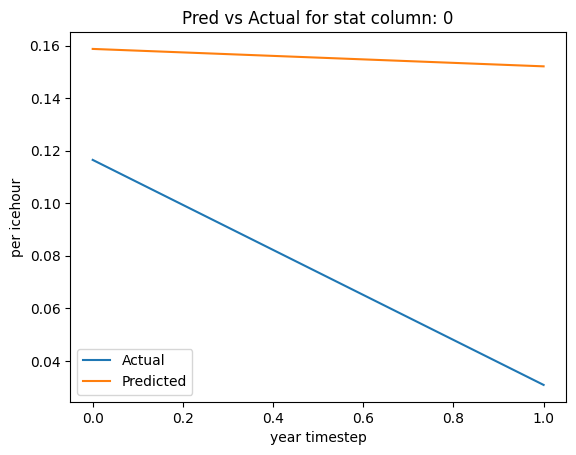

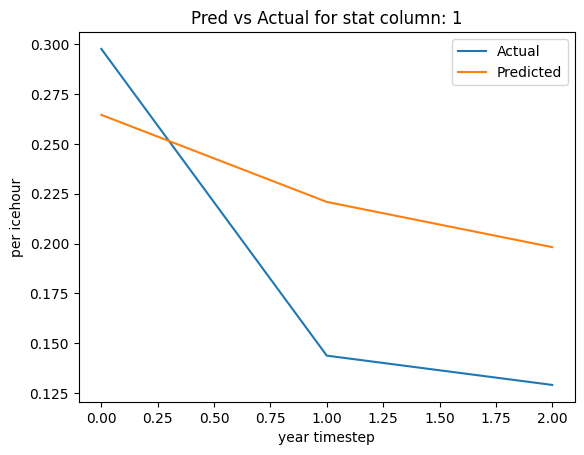

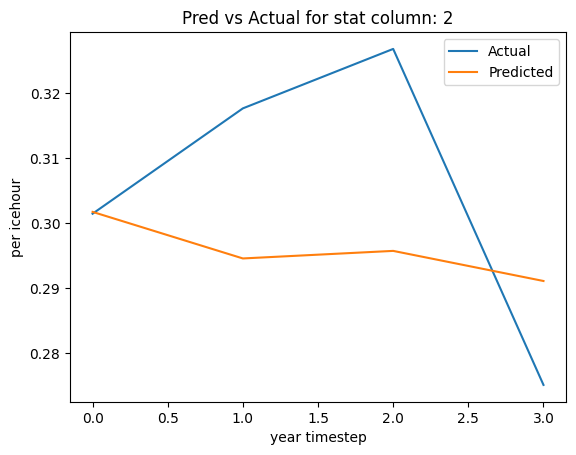

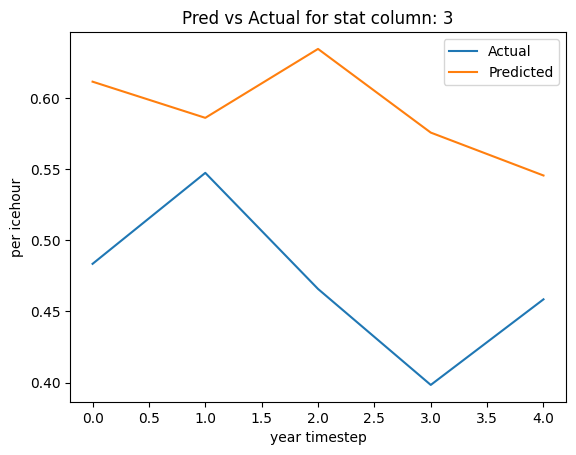

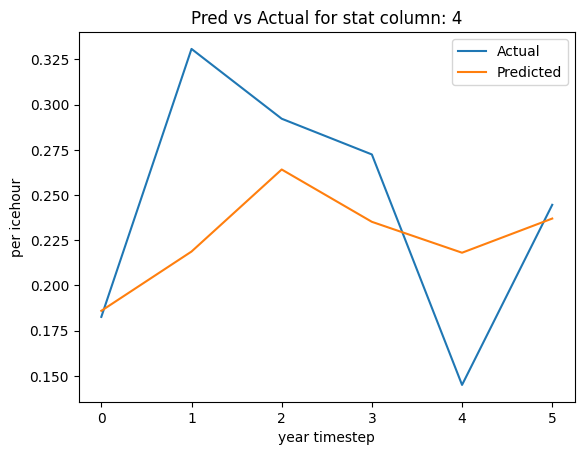

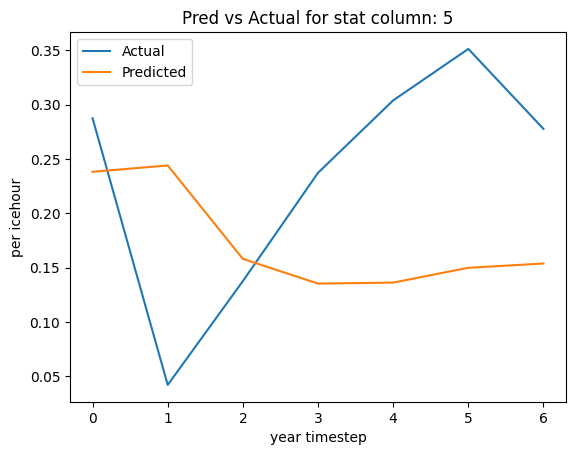

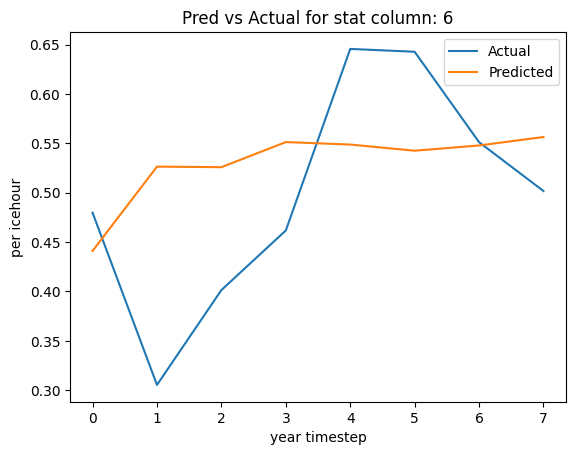

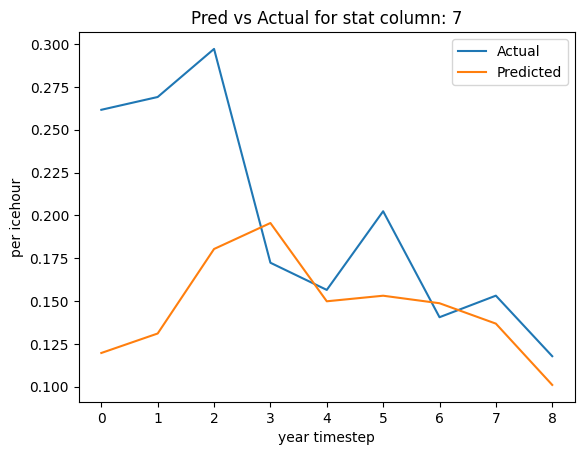

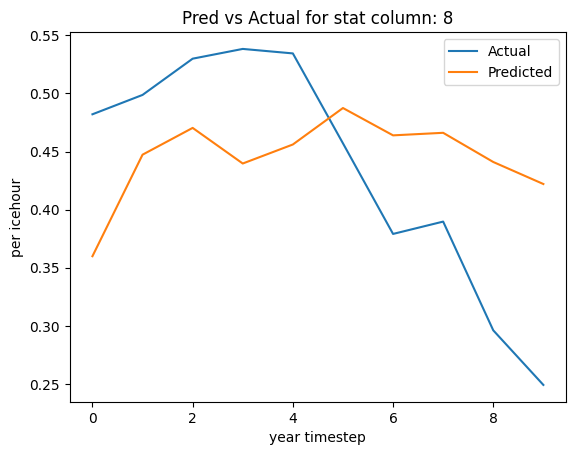

In [ ]:
# start for seq length 3, because at 2 its just a single point
for i in range(3, 12):
    # make prediction
    i_src_mask = generate_square_subsequent_mask(i-1).to(device)
    i_output = model(test_x_by_seq_len['length' + str(i)][0, :, :, :].to(torch.float32).to(device), i_src_mask)
    
    # show different columns, hence i-2
    pred_line = i_output[:,0,i-3].detach().cpu().numpy()
    y_actual = test_y_by_seq_len['length' + str(i)][0,:,0,i-3].detach().numpy()

    # for x axis
    x_axis = np.arange(len(pred_line))
    
    # Plotting the lines
    plt.plot(x_axis, y_actual, label='Actual')
    plt.plot(x_axis, pred_line, label='Predicted')

    # Adding labels and title
    plt.xlabel('year timestep')
    plt.ylabel('per icehour')
    plt.title('Pred vs Actual for stat column: ' + str(i-3))

    # Adding a legend
    plt.legend()

    # Displaying the graph
    plt.show()

## Save Model (if necessary)

In [ ]:
# if the model is good, save

In [ ]:
torch.save(model.state_dict(), "best_model_weights.pth")